[*********************100%***********************]  1 of 1 completed


X_train shape: torch.Size([1095, 50, 8])
y_train shape: torch.Size([1095])
Epoch 1/300, Loss: 0.100990
Epoch 11/300, Loss: 0.090055
Epoch 21/300, Loss: 0.080076
Epoch 31/300, Loss: 0.070854
Epoch 41/300, Loss: 0.062386
Epoch 51/300, Loss: 0.054299
Epoch 61/300, Loss: 0.047909
Epoch 71/300, Loss: 0.042099
Epoch 81/300, Loss: 0.036898
Epoch 91/300, Loss: 0.032643
Epoch 101/300, Loss: 0.029450
Epoch 111/300, Loss: 0.027388
Epoch 121/300, Loss: 0.025692
Epoch 131/300, Loss: 0.023207
Epoch 141/300, Loss: 0.020317
Epoch 151/300, Loss: 0.017430
Epoch 161/300, Loss: 0.014536
Epoch 171/300, Loss: 0.011883
Epoch 181/300, Loss: 0.009325
Epoch 191/300, Loss: 0.007287
Epoch 201/300, Loss: 0.005993
Epoch 211/300, Loss: 0.005261
Epoch 221/300, Loss: 0.004757
Epoch 231/300, Loss: 0.004505
Epoch 241/300, Loss: 0.004186
Epoch 251/300, Loss: 0.004023
Epoch 261/300, Loss: 0.003735
Epoch 271/300, Loss: 0.003631
Epoch 281/300, Loss: 0.003495
Epoch 291/300, Loss: 0.003292


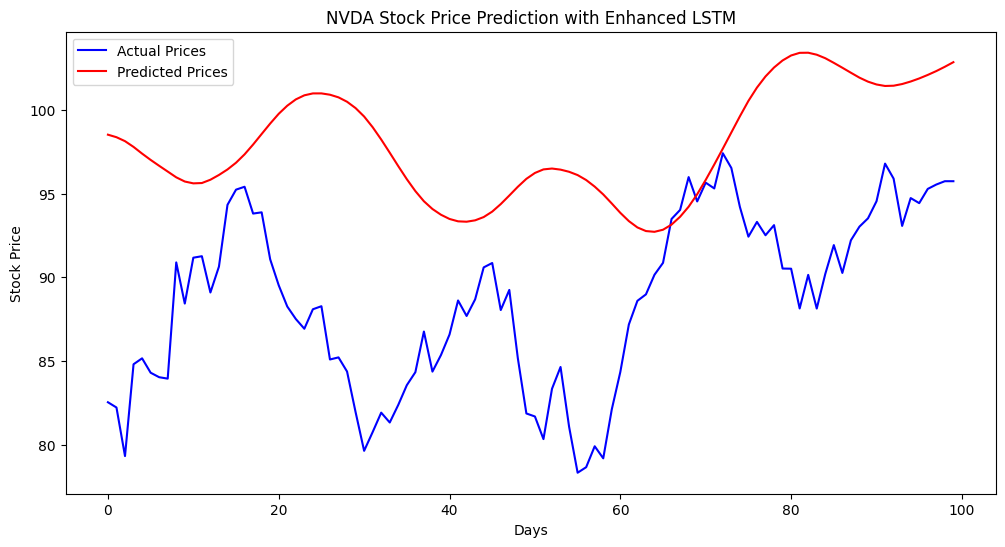

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

#  Load Stock Price Data with Additional Features
ticker = "NVDA"  
df = yf.download(ticker, start="2019-01-01", end="2024-01-01")[["Open", "High", "Low", "Close", "Volume"]]

# Add Technical Indicators (SMA, EMA, RSI)
df["SMA_10"] = df["Close"].rolling(window=10).mean()
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()

# Relative Strength Index (RSI)
delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# Drop NaN values due to indicator calculations
df.dropna(inplace=True)

# Normalize Data (Scaling each feature independently)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

#  Create Sequences for LSTM (Multi-Feature Input)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Take `seq_length` time steps
        y.append(data[i+seq_length, 3])  # Predicting "Close" Price (Index 3)
    return np.array(X), np.array(y)

seq_length = 50  # Use last 50 days to predict the next day
X, y = create_sequences(df_scaled, seq_length)

#  Convert to PyTorch tensors (Ensure Correct Shape)
X_train, y_train = torch.tensor(X[:-100], dtype=torch.float32), torch.tensor(y[:-100], dtype=torch.float32)
X_test, y_test = torch.tensor(X[-100:], dtype=torch.float32), torch.tensor(y[-100:], dtype=torch.float32)

# Print Shape for Debugging
print("X_train shape:", X_train.shape)  # (samples, seq_length, num_features)
print("y_train shape:", y_train.shape)  # (samples,)

# Define Enhanced LSTM Model
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0.2):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Use last LSTM output

# Initialize Model with Correct Input Size
input_size = X_train.shape[2]  # Number of features
model = StockPredictor(input_size)

#  Train Model with Improved Training Strategy
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.85)  # Decay learning rate

epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)  # Correct shape
    loss = criterion(output, y_train.unsqueeze(-1))  # Ensure correct loss shape
    loss.backward()
    optimizer.step()
    scheduler.step()  # Adjust learning rate

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

#  Predict Future Prices & Fix Scaling Issue
model.eval()
predicted = model(X_test).detach().numpy()

# Correctly Rescale Only the Close Price
predicted = scaler.inverse_transform(np.column_stack([np.zeros((predicted.shape[0], df_scaled.shape[1] - 1)), predicted]))[:, -1]
actual = scaler.inverse_transform(np.column_stack([np.zeros((y_test.shape[0], df_scaled.shape[1] - 1)), y_test.numpy().reshape(-1, 1)]))[:, -1]

#  Plot Results
plt.figure(figsize=(12, 6))
plt.plot(actual, label="Actual Prices", color="blue")
plt.plot(predicted, label="Predicted Prices", color="red")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title(f"{ticker} Stock Price Prediction with Enhanced LSTM")
plt.legend()
plt.show()



In [8]:
# Load Stock Price Data
import yfinance as yf
ticker = "NVDA"  # Apple Stock
df = yf.download("NVDA", start="2023-01-01", end="2024-01-01", progress=False, threads=False)
df.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2023-01-03,14.304595,14.985101,14.085754,14.840206,401277000
2023-01-04,14.738278,14.842203,14.230648,14.556411,431324000
2023-01-05,14.254631,14.553413,14.137716,14.480467,389168000
2023-01-06,14.848201,14.999091,14.023801,14.463480,405044000
2023-01-09,15.616642,16.044330,15.129995,15.272892,504231000
